In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import os

In [36]:
# set variables
device = "cuda"  # cpu or cuda

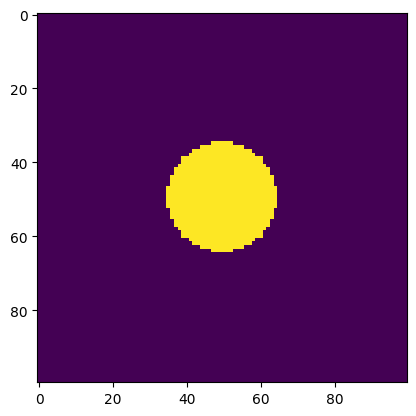

In [37]:
# data preparation

# this cell should be filled with your code for dataloading


# As an example, we use a shor sequence of an circle oscillating in y direction
from generate_example_sequence import generate_sequence
sequence, path = generate_sequence(width=100, height=100, num_frames=100,
                                   radius=0.3, amplitude=0.3, frequency=1, dtype=np.uint8)

initial_mask = (sequence[0].copy() > 0).astype(np.uint8)

# maybe add some (static) noise to the sequence
noise = 0.0
if noise > 0:
    np.random.seed(0)
    sequence = sequence + noise * np.random.uniform(0, 1, sequence[0].shape)
    sequence = ((200/(1+noise))*sequence).astype(np.uint8)

# convert the sequence to a rgb numpy array
sequence = np.repeat(sequence[..., None], 3, axis=3)


# at this point sequence should be a numpy array of shape (T,H,W,C) where C=3 (rgb)
assert sequence.shape[3] == 3
assert sequence.dtype == np.uint8

# and initial_mask should be a binary mask of shape (H,W) with values in {0,1}
assert initial_mask.shape == sequence.shape[1:3]
assert np.all(np.isin(np.unique(initial_mask), [0, 1]))
plt.imshow(sequence[0, :, :, 0])

In [38]:
T, H, W, C = sequence.shape

# 1. ContourTracker


In [39]:
# load the foundation models

# cotracker2
from cotracker.predictor import CoTrackerOnlinePredictor
cotracker_predictor = CoTrackerOnlinePredictor("./checkpoints/cotracker2.pth").to(device)

# repvit_sam -> smaller and faster version of sam
from repvitsam.predictor import SamPredictor
from repvitsam.build_sam import build_sam_repvit

sam_predictor = SamPredictor(build_sam_repvit("./checkpoints/repvit_sam.pt").to(device))


In [40]:
# the contourtracker approach requires a few helper functions
from contourtracker_utils import queries_from_points, \
    compute_logits_from_mask_torch, compute_sam_box, points_to_mask, \
    compute_largest_contour, interp_1d, compute_bounding_box, compute_dice_score_torch
from cotracker.models.core.model_utils import get_points_on_a_grid

In [41]:
# preparing cotracker queries

def prepare_queries(mask,
                    fixed_contour_count,
                    device,
                    bulk_grid_size,
                    bulk_margin,
                    cotracking_grid_size,
                    original_size):

    # queries_ is a list of cotracking points
    # index is a dictionary that maps the query type to the start index and length of the queries in the queries list
    queries_ = []
    index = {}

    contour = compute_largest_contour(mask)

    # the contour is interpolated to fixed_contour_count points
    # this is done to make the runtime of the model predictable.
    contour = interp_1d(contour, fixed_contour_count)
    queries = queries_from_points(contour, 0, device)

    index["contour"] = (0, queries.shape[1])
    queries_.append(queries)

    # local cotracking points
    if bulk_grid_size > 0:

        # grid_pts = get_points_on_a_grid(bulk_grid_size, mask.shape, device=frames.device)
        m = bulk_margin  # 0.2
        box = compute_bounding_box(mask)
        # create a local grid of points around the bounding box
        bulk_points = get_points_on_a_grid(
            cotracking_grid_size,
            ((1.0 + m)*(box[3] - box[1]), (1.0 + m)*(box[2] - box[0])),
            device=device
        )
        # shift local grid to the position of the bounding box
        bulk_points += torch.tensor([box[0], box[1]], device=device).float() - (
            m/2) * torch.tensor([box[3] - box[1], box[2] - box[0]], device=device).float()

        # clamp points to image boundaries
        bulk_points[0, :, 0] = torch.clamp(
            bulk_points[0, :, 0], 0, original_size[0]-1)
        bulk_points[0, :, 1] = torch.clamp(
            bulk_points[0, :, 1], 0, original_size[1]-1)

        # add a t=0 channel to the points
        bulk_queries = torch.cat(
            [torch.zeros_like(bulk_points[:, :, :1]), bulk_points], dim=2)

        index["local_cotracking_grid"] = (
            sum([q.shape[1] for q in queries_]), bulk_queries.shape[1])
        queries_.append(bulk_queries)

    # global cotracking points
    if cotracking_grid_size > 0:
        # create a global grid of points covering the whole image
        grid_pts = get_points_on_a_grid(
            cotracking_grid_size, original_size, device=device)

        # add a t=0 channel to the points
        grid_pts = torch.cat(
            [torch.zeros_like(grid_pts[:, :, :1]), grid_pts], dim=2)

        index["global_cotracking_grid"] = (
            sum([q.shape[1] for q in queries_]), grid_pts.shape[1])
        queries_.append(grid_pts)

    queries = torch.cat(queries_, dim=1)
    return queries, index

In [42]:
# refine mask with sam

def refine_with_sam(cotracker_mask, sam_predictor, frame, original_size, sam_pass_box_margin=0.5, mask_threshold=0.0, embedding=None):

    mask_prompt = compute_logits_from_mask_torch(
        cotracker_mask.unsqueeze(0)).squeeze(0)

    box = compute_sam_box(sam_predictor, cotracker_mask,
                          original_size, margin=sam_pass_box_margin)
    sam_prepred_frame = sam_predictor.transform.apply_image_torch(
        frame.unsqueeze(0)).squeeze(0)

    chunk = [{
        "mask_inputs": mask_prompt.unsqueeze(0),  # Bx1xHxW
        "boxes": box.unsqueeze(0),  # Bx4
        "image": sam_prepred_frame,
        "original_size": original_size,
        "mask_threshold": mask_threshold,
        # **({"image_embedding":embedding} if embedding is not None else {})
    }]
    res = sam_predictor.model.forward(
        chunk, multimask_output=True)  # B NumMasks H W

    frame_seg = res[0]
    # reshape
    frame_seg["masks"] = frame_seg["masks"].reshape(1, -1, *original_size)
    frame_seg["low_res_logits"] = frame_seg["low_res_logits"].reshape(
        1, -1, *frame_seg["low_res_logits"].shape[-2:])
    frame_seg["iou_predictions"] = frame_seg["iou_predictions"].reshape(1, -1)

    masks = []
    iou_predictions = []
    logits = []
    # use the third sam mask -> which is the closest to the prompt
    masks.append(frame_seg["masks"][:, -2:-1])
    logits.append(frame_seg["low_res_logits"][:, -2:-1])
    iou_predictions.append(frame_seg["iou_predictions"])

    masks = torch.stack(masks).squeeze(1, 2)
    iou_predictions = torch.stack(iou_predictions).squeeze(1)
    logits = torch.stack(logits).squeeze(1, 2)
    return masks, iou_predictions, logits

In [43]:
def dynamic_thresholding(initial_mask, logits, thresholds=np.linspace(-5.0, 5.0, 25)):
    initial_mask_torch = torch.tensor(initial_mask, device=logits.device)

    # interpolate the logits to the size of the initial mask
    scaled_logits = torch.nn.functional.interpolate(
        logits.unsqueeze(1),
        initial_mask.shape,
        mode="bilinear",
        align_corners=False,
    ).squeeze(0, 1)

    # find the best threshold with a basic grid search
    best_threshold = 0.0
    best_dice = 0.0
    for threshold in thresholds:
        d_score = compute_dice_score_torch(
            scaled_logits > threshold, initial_mask_torch)
        if d_score > best_dice:
            best_dice = d_score
            best_threshold = threshold
    # set mask threshold to the best threshold
    return best_threshold

In [44]:
# transform the sequence to a tensor with shape (T,C,H,W) -> channel-first required by the model
frames = torch.tensor(sequence.copy(), dtype=torch.float,
                      device=device).permute(0, 3, 1, 2)
original_size = frames.shape[2:]
frames.shape

torch.Size([100, 3, 100, 100])

In [45]:
%%time

# prepare the queries for the cotracker model
queries, index = prepare_queries(initial_mask,
    fixed_contour_count=50,
    device=device,
    bulk_grid_size=21,
    bulk_margin=0.5,
    cotracking_grid_size=21,
    original_size=initial_mask.shape)
# BxNxC where B=1, C=3, N=number of queries

with torch.inference_mode(): # run in inference_mode, as we don't need gradients
    original_size = (H, W)
    
    # setup cotracker
    cotracker_predictor(video_chunk=frames.unsqueeze(0), is_first_step=True, queries=queries)

    # run cotracker on the whole sequence
    step = cotracker_predictor.step
    WINDOW = 2 * step
    for i in range(0, frames.shape[0] - step, step):
        pred_tracks, raw_pred_visibility = cotracker_predictor(
            video_chunk=frames[i : i + WINDOW].unsqueeze(0), iters=6
        )
    
    # the predicted visibility is ignored, as mri has no occlusions the way real world videos have
    #visibility_threshold = 0.0
    #pred_visibility = (raw_pred_visibility > visibility_threshold) if visibility_threshold>0 else torch.ones_like(raw_pred_visibility, dtype=torch.bool)
    
    cotracker_masks = torch.zeros((T, H, W), dtype=torch.bool, device=device)
    for i in range(0, frames.shape[0]):
        cotracker_masks[i] = torch.tensor(
            points_to_mask(pred_tracks[0,i,:index["contour"][1]].cpu().numpy(), shape=(H,W)), 
            device=device)
        
    results = {
        "masks": cotracker_masks,
        # other results that might be useful but are not used in this example
        #"prompts": pred_tracks[:,:,:index["contour"][1]],
        #"cotracking_prompts": pred_tracks[:,:,index["contour"][1]:],
        #"pred_visibility": pred_visibility,
        #"raw_pred_visibility": raw_pred_visibility
    }
    # prepare results for SAM mask refinement
    results["scores"] = torch.zeros(cotracker_masks.shape[0], dtype=torch.float32, device=device)
    results["logits"] = torch.zeros((cotracker_masks.shape[0], 256, 256), dtype=torch.float32, device=device)
    
    -10 -1 
    # log(p_i)
    
    # initialize sam_mask_threshold with 0.0
    sam_mask_threshold = 0.0
    
    # refine the masks with sam
    for i in range(0, frames.shape[0]):
        mask, score, logits = refine_with_sam(cotracker_masks[i].detach().clone(),
                                             sam_predictor, 
                                             frames[i].detach().clone(), 
                                             original_size=(H,W), 
                                             sam_pass_box_margin=0.5, 
                                             mask_threshold=sam_mask_threshold,
                                             embedding=None)
        
        
        if i == 0: # apply dynamic thresholding on first frame
            # set mask threshold to the best threshold
            sam_mask_threshold = dynamic_thresholding(initial_mask, logits)

        results["scores"][i] = score[0,-1]
        results["logits"][i] = logits[0]
        results["masks"][i] = mask
    

CPU times: user 9.33 s, sys: 13.3 ms, total: 9.35 s
Wall time: 9.34 s


In [46]:
# evaluate the results

Text(0.5, 1.0, 'predicted mask')

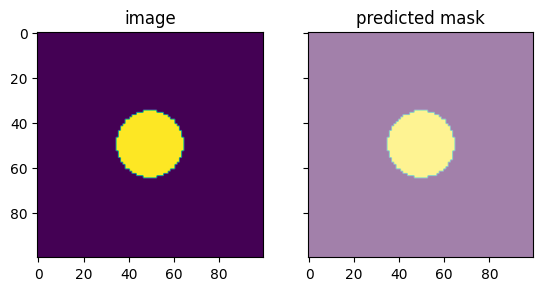

In [47]:
# preview of the first mask
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].imshow(sequence[0,:,:,0])
axs[1].imshow(results["masks"][0].cpu().numpy(), alpha=0.5)
axs[0].set_title("image")
axs[1].set_title("predicted mask")

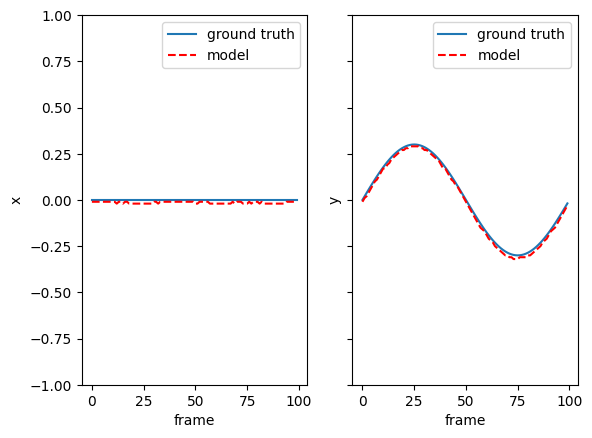

In [48]:
# as an example evaluation we compute the bbox center position of the predicted masks
# and compare it to the ground truth path

bounding_boxes = np.array([compute_bounding_box(
    mask.cpu().numpy()) for mask in results["masks"]])
box_centers = np.stack((bounding_boxes[:, [0, 2]].mean(
    axis=1), bounding_boxes[:, [1, 3]].mean(axis=1)), axis=1)
scaling = np.array([W//2, H//2])
box_centers = (box_centers - scaling) / scaling

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

axs[0].plot(path[:, 0], "-", label="ground truth")
axs[0].plot(box_centers[:, 0], "--", c="red", label="model")
axs[1].plot(path[:, 1], "-", label="ground truth")
axs[1].plot(box_centers[:, 1], "--", c="red", label="model")


axs[0].set_xlabel('frame')
axs[1].set_xlabel('frame')
axs[0].set_ylabel('x')
axs[1].set_ylabel('y')
axs[0].set_ylim(-1, 1)
axs[0].legend()
axs[1].legend()

In [49]:
# clean up before running the SAM2 based method
del sam_predictor
del cotracker_predictor
torch.cuda.empty_cache()
del frames
del queries
del results
del cotracker_masks
del pred_tracks
del raw_pred_visibility
del box_centers
del bounding_boxes

# 2. SAM2

As an alternative model, we implemented


In [50]:
device = "cuda"  # sam2 does not work on cpu only

In [51]:
# reset frames and initial_mask variables
frames = sequence.copy()  # TxHxWxC where C=3 (rgb)
initial_mask = initial_mask  # HxW
initial_mask.shape, frames.shape

((100, 100), (100, 100, 100, 3))

In [52]:
# Load sam2 as an alternative foundationmodel

from sam2.build_sam import build_sam2_video_predictor

checkpoint = "./checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"  # see sam2/sam2_configs/ for more configs

predictor = build_sam2_video_predictor(model_cfg, checkpoint, device="cuda")
# disable hole filling as is is requires nvcc compilation
predictor.fill_hole_area = 0

In [53]:
# SAM2 expects a video directory with JPEG frames
# This is accomplished by saving the frames temporarily to disk

folder_path = "./.temp"
os.makedirs(folder_path, exist_ok=True)

for i in range(0, len(frames)):
    image = frames[i]
    jpg_file_path = os.path.join(folder_path, f"{i:06d}.jpg") # 6 digit names 000000.jpg, 000001.jpg, ...
    # 80 quality is a good trade-off between file size and quality
    cv2.imwrite(jpg_file_path, image, [int(cv2.IMWRITE_JPEG_QUALITY), 80])

# check if the frames are written to disk
!ls {folder_path} | head -n 3
print("...")
print("--- Total frames ---")
!ls {folder_path} | wc -l

000000.jpg
000001.jpg
000002.jpg
...
--- Total frames ---
100


In [54]:
%%time

results = {
    "logits": [],
    "masks": [],
    "scores": []
}
with torch.inference_mode(): # again we are using inference_mode
    # initialize the state
    inference_state = predictor.init_state(video_path=folder_path)

    # add the initial mask to the state
    frame_idx, obj_ids, video_res_masks = predictor.add_new_mask(
            inference_state=inference_state,
            frame_idx=0, obj_id=1,
            mask=initial_mask)
    
    sam_mask_threshold = None
    # propagate the mask through the video
    mask_iterator = predictor.propagate_in_video(inference_state, yield_scores=True)
    for frame_idx, obj_ids, video_res_masks, scores in mask_iterator:
        
        if sam_mask_threshold == None: # first pass -> dynamic thresholding
            # set mask threshold to the best threshold
            sam_mask_threshold = dynamic_thresholding(initial_mask, logits)

        results["logits"].append(video_res_masks)
        results["masks"].append(video_res_masks > sam_mask_threshold)
        results["scores"].append(scores[0,-1])

results["logits"] = torch.stack(results["logits"]).squeeze(1,2)
results["masks"] = torch.stack(results["masks"]).squeeze(1,2)
results["scores"] = torch.tensor(results["scores"])

propagate in video: 100%|██████████| 100/100 [00:21<00:00,  4.57it/s]

CPU times: user 1min 15s, sys: 3.13 s, total: 1min 18s
Wall time: 24.7 s


In [55]:
# we can now clean up the temporary directory
!rm -r {folder_path}

In [56]:
# evaluate the results

Text(0.5, 1.0, 'predicted mask')

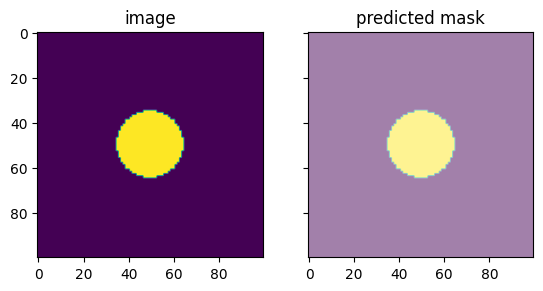

In [57]:
# preview of the first mask
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
axs[0].imshow(sequence[0,:,:,0])
axs[1].imshow(results["masks"][0].cpu().numpy(), alpha=0.5)
axs[0].set_title("image")
axs[1].set_title("predicted mask")

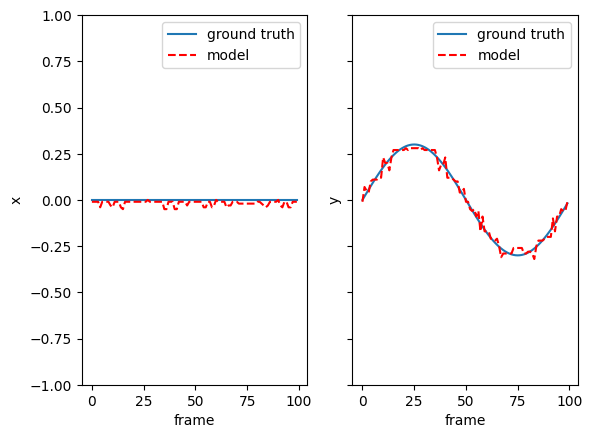

In [58]:
# as an example evaluation we compute the bbox center position of the predicted masks and compare it to the ground truth path
bounding_boxes = np.array([compute_bounding_box(
    mask.cpu().numpy()) for mask in results["masks"]])
box_centers = np.stack((bounding_boxes[:, [0, 2]].mean(
    axis=1), bounding_boxes[:, [1, 3]].mean(axis=1)), axis=1)
scaling = np.array([W//2, H//2])
box_centers = (box_centers - scaling) / scaling

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)

axs[0].plot(path[:, 0], "-", label="ground truth")
axs[0].plot(box_centers[:, 0], "--", c="red", label="model")
axs[1].plot(path[:, 1], "-", label="ground truth")
axs[1].plot(box_centers[:, 1], "--", c="red", label="model")


axs[0].set_xlabel('frame')
axs[1].set_xlabel('frame')
axs[0].set_ylabel('x')
axs[1].set_ylabel('y')
axs[0].set_ylim(-1, 1)
axs[0].legend()
axs[1].legend()